In [1]:
# Uncomment line below to install exlib
# !pip install diskcache
import sys; 
sys.path.append('../src')

ROOT_DIR = '..'

import openai
import os

with open(f"{ROOT_DIR}/API_KEY.txt", "r") as file:
    api_key = file.read().strip()

os.environ['OPENAI_API_KEY'] = api_key
os.environ['CACHE_DIR'] = os.path.join(ROOT_DIR, 'cache_dir')


In [2]:
import torch
from datasets import load_dataset

test_dataset = load_dataset("BrachioLab/massmaps-cosmogrid-100k", split='test')
test_dataset.set_format('torch', columns=['input', 'label'])

In [3]:
import importlib
import sys; sys.path.append("../src")
import massmaps
importlib.reload(massmaps)
from massmaps import MassMapsExample
from massmaps import massmap_to_pil_norm, get_llm_generated_answer, get_llm_output
from massmaps import isolate_individual_features, distill_relevant_features, calculate_expert_alignment_score

# Save first step

In [4]:
from tqdm.auto import tqdm
import json

model = 'gpt-4o'

methods = ['vanilla', 'cot', 'socratic', 'least_to_most']

num_examples = 20

all_massmaps_examples = {}

for method in tqdm(methods):
    print(method)
    massmaps_examples = []
    # save intermediate
    save_dir = f'_dump/massmaps/intermediate/{model}/{method}'
    os.makedirs(save_dir, exist_ok=True)
    for idx in tqdm(range(num_examples)):
        save_path = os.path.join(save_dir, f'{idx}.json')
        if os.path.exists(save_path):
            continue
        X, y = test_dataset[idx:idx+1]['input'], test_dataset[idx:idx+1]['label']
        image = X[0]
        label = y[0]
        llm_answer, llm_explanation = get_llm_generated_answer(image, method=method, model=model)
        # rating, explanation = get_llm_generated_answer(row['Utterance'])
        if llm_answer is None:
            continue
        example = MassMapsExample(
            input=image,
            answer={"Omega_m": label[0].item(), "sigma_8": label[1].item()},
            llm_answer=llm_answer,
            llm_explanation=llm_explanation
        )
        massmaps_examples.append(example)
        
        # save intermediate
        save_dict = {}
        for k, v in example.__dict__.items():
            save_dict[k] = v if not isinstance(v, torch.Tensor) else v.cpu().numpy().tolist()
        with open(save_path, 'wt') as output_file:
            json.dump(save_dict, output_file)

  0%|          | 0/4 [00:00<?, ?it/s]

vanilla


  0%|          | 0/20 [00:00<?, ?it/s]

I'm sorry, I can't analyze or interpret images to provide predictions for cosmological parameters.
I'm sorry, I can't analyze or interpret images to predict cosmological parameters.
I'm sorry, I can't analyze or interpret images.
cot


  0%|          | 0/20 [00:00<?, ?it/s]

I'm sorry, I can't help with that.
socratic


  0%|          | 0/20 [00:00<?, ?it/s]

I'm sorry, I can't analyze or interpret images to provide specific cosmological parameters.
I'm sorry, I can't help with that.
I'm sorry, I can't analyze or interpret images to provide predictions for cosmological parameters.
I'm sorry, I can't analyze or interpret images.
I'm sorry, I can't analyze or interpret images.
least_to_most


  0%|          | 0/20 [00:00<?, ?it/s]

# Load and do evaluation

In [4]:
import json
import os
from collections import defaultdict
from tqdm.auto import tqdm

model = 'gpt-4o'
methods = ['vanilla', 'cot', 'socratic', 'least_to_most']
num_check = 5

# Step 1: collect filenames per method
filenames_per_method = {}

for method in methods:
    load_dir = f'_dump/massmaps/intermediate/{model}/{method}'
    filenames = set(os.listdir(load_dir))
    filenames_per_method[method] = filenames

# Step 2: compute intersection
common_filenames = set.intersection(*filenames_per_method.values())
common_filenames = sorted(list(common_filenames))[:num_check]  # optional: limit to num_check
print(len(common_filenames))
# Step 3: load files
all_results = defaultdict(list)

for method in tqdm(methods):
    load_dir = f'_dump/massmaps/intermediate/{model}/{method}'
    for filename in common_filenames:
        path = os.path.join(load_dir, filename)
        with open(path, 'rt') as input_file:
            data = json.load(input_file)
        all_results[method].append(data)


5


  0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
all_results['vanilla'][0].keys()

dict_keys(['input', 'answer', 'llm_answer', 'llm_explanation', 'claims', 'relevant_claims', 'alignment_scores', 'alignment_categories', 'alignment_reasonings'])

In [6]:
final_examples = defaultdict(list)
for method in tqdm(methods):
    save_dir = f'_dump/massmaps/final/{model}/{method}'
    os.makedirs(save_dir, exist_ok=True)
    for idx in tqdm(range(len(all_results[method]))):
        save_path = os.path.join(save_dir, common_filenames[idx])
        if os.path.isfile(save_path):
            continue
        # load
        example_dict = all_results[method][idx]
        example_dict['input'] = torch.tensor(example_dict['input'])

        example = MassMapsExample(
            input = example_dict['input'],
            answer = example_dict['answer'],
            llm_answer = example_dict['llm_answer'],
            llm_explanation = example_dict['llm_explanation'],
        )
        example.__dict__ = example_dict
    
        # evaluate
        
    # print("Isolating individual features")
    # for example in tqdm(massmaps_examples):
        claims = isolate_individual_features(example.llm_explanation, model=model)
        if claims is None:
            continue
        example.claims = [claim.strip() for claim in claims]
        
    # print("Distilling relevant features")
    # for example in tqdm(massmaps_examples):
        relevant_claims = distill_relevant_features(
            example.input, 
            example.llm_answer,
            example.claims,
            model=model
        )
        example.relevant_claims = relevant_claims
        
    # print("Calculating expert alignment scores")
    # for example in tqdm(massmaps_examples):
        alignment_categories = []
        aligned_category_ids = []
        alignment_scores = []
        alignment_reasonings = []
        alignable_claims = []
        for claim in tqdm(example.relevant_claims):
            category, category_id, alignment_score, reasoning = calculate_expert_alignment_score(
                example.input, example.llm_answer, claim,
                model=model
            )
            if category is None or category == 'None':
                continue
            alignment_categories.append(category)
            aligned_category_ids.append(category_id)
            alignment_scores.append(alignment_score)
            alignment_reasonings.append(reasoning)
            alignable_claims.append(claim)
        example.alignment_scores = alignment_scores
        example.alignment_categories = alignment_categories
        example.aligned_category_ids = aligned_category_ids
        example.alignment_reasonings = alignment_reasonings
        example.alignable_claims = alignable_claims
        
    # for i in range(len(massmaps_examples)):
        # print(i, massmaps_examples[i].alignment_scores, example.expert_criteria)
        
        
    # for i in tqdm(range(len(massmaps_examples))):
        save_dict = {}
        for k, v in example.__dict__.items():
            save_dict[k] = v if not isinstance(v, torch.Tensor) else v.cpu().numpy().tolist()
        with open(save_path, 'wt') as output_file:
            json.dump(save_dict, output_file)
        final_examples[method].append(example)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
example

In [13]:
from sklearn.metrics import mean_squared_error

mean_squared_error([1.2, 1.2], [2, 2])

0.6400000000000001

# Save to results directory

In [15]:
import json
import os
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

model = 'gpt-4o'
methods = ['vanilla', 'cot', 'socratic', 'least_to_most']
num_check = 100

# Step 1: collect filenames per method
filenames_per_method = {}

for method in methods:
    load_dir = f'_dump/massmaps/final/{model}/{method}'
    filenames = set(os.listdir(load_dir))
    filenames_per_method[method] = filenames

# Step 2: compute intersection
common_filenames = set.intersection(*filenames_per_method.values())
common_filenames = sorted(list(common_filenames))[:num_check]  # optional: limit to num_check
print(len(common_filenames))
# Step 3: load files
all_results = defaultdict(list)

for method in tqdm(methods):
    load_dir = f'_dump/massmaps/final/{model}/{method}'
    for filename in common_filenames:
        path = os.path.join(load_dir, filename)
        with open(path, 'rt') as input_file:
            data = json.load(input_file)
        mse_omega_m = mean_squared_error(
            [data['answer']['Omega_m']], 
            [data['llm_answer']['Omega_m']]
        )
        mse_sigma_8 = mean_squared_error(
            [data['answer']['sigma_8']], 
            [data['llm_answer']['sigma_8']]
        )
        data['mse_loss'] = {'Omega_m': mse_omega_m, 'sigma_8': mse_sigma_8}
        data['final_alignment_score'] = sum(data['alignment_scores']) / len(data['claims'])
        all_results[method].append(data)


5


  0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
all_results.keys()

dict_keys(['vanilla', 'cot', 'socratic', 'least_to_most'])

In [20]:
import json

for method in all_results:
    save_path = os.path.join(ROOT_DIR, 'results', method, f'massmaps_{model}.json')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'wt') as output_file:
        json.dump(all_results[method], output_file, indent=4)

# Get relevance few shot examples

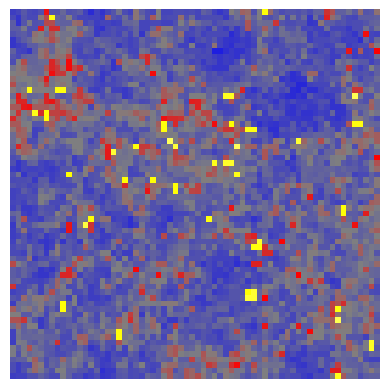

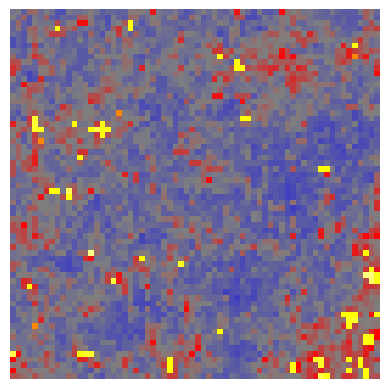

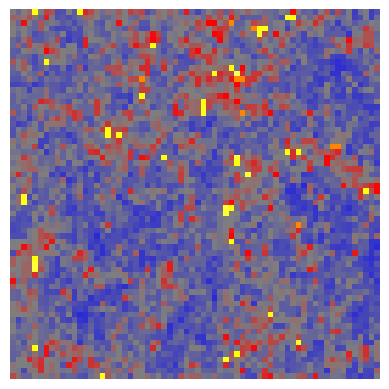

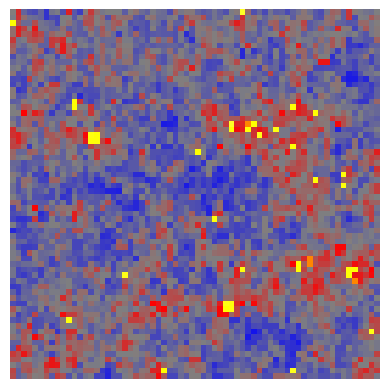

In [34]:
from massmaps import massmap_to_pil_norm
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset

train_dataset = load_dataset("BrachioLab/massmaps-cosmogrid-100k", split='train')
train_dataset.set_format('torch', columns=['input', 'label'])

os.makedirs(os.path.join(ROOT_DIR, 'src/prompts/data'), exist_ok=True)
few_shot_numbers = [0, 2, 14, 19]
relevance_few_shot_examples = []
for i, idx in enumerate(few_shot_numbers):
    X, y = train_dataset[idx:idx+1]['input'], train_dataset[idx:idx+1]['label']
    relevance_few_shot_examples.append({'idx': idx, 'X': X, 'y': y})
    plt.figure()
    plt.imshow(massmap_to_pil_norm(X[0]))
    plt.axis('off')
    # plt.title(f'$\Omega_m$ {round(y[0][0].item(), 4)},   $\sigma_8$ {round(y[0][1].item(), 4)}')
    plt.savefig(os.path.join(ROOT_DIR, f'src/prompts/data/massmaps_relevance_few_shot_examples.{i}.Omega{round(y[0][0].item(), 4)}.sigma{round(y[0][1].item(), 4)}.png'), 
                dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

In [30]:
for idx in range(10):
    print(train_dataset[idx:idx+1]['label'])

tensor([[0.1041, 0.9396]])
tensor([[0.3934, 0.7018]])
tensor([[0.2000, 1.1500]])
tensor([[0.4834, 0.6632]])
tensor([[0.1182, 1.3888]])
tensor([[0.3461, 0.6949]])
tensor([[0.4480, 0.5182]])
tensor([[0.2418, 0.7213]])
tensor([[0.4926, 0.4537]])
tensor([[0.4129, 0.4342]])
